In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import preprocessing
import running_model
from scipy import stats
#visualisation libraries
import matplotlib.pyplot as plt
import networkx as nx
import visualisation

# Data Importing and Preprocessing

In [4]:
ID,babies_connectivity_matrix=preprocessing.babies_connectivity_extraction('./Tracts/')
ROIs_combinations=preprocessing.ROIs_combinations('./Regions_of_interests.csv')
structural_labels=pd.read_csv('all_labels.csv', header = None, sep='\t')
structural_labels=np.asarray(structural_labels[1])
babies_structural_matrix=pd.read_csv('./ePrime-structure-volumes.csv',header=0,index_col=None).dropna()
babies_structural_matrix=babies_structural_matrix.iloc[babies_structural_matrix['Age at scan'].values<49,:].reset_index(drop=True)

this file dataProb_EP1085_mat.txt is not processed
this file dataProb_EP1078_mat.txt is not processed
this file cannot be loaded: .DS_Store
this file dataProb_EP1118_mat.txt is not processed
this file dataProb_EP1009_mat.txt is not processed
this file dataProb_EP1092_mat.txt is not processed
this file dataProb_EP1142_mat.txt is not processed
this file dataProb_EP1130_mat.txt is not processed
this file dataProb_EP1041_mat.txt is not processed
this file dataProb_EP1017_mat.txt is not processed
this file dataProb_EP1105_mat.txt is not processed
this file dataProb_EP1123_mat.txt is not processed


In [5]:
#Reading necessary tables
schizophrenia_high_scores_european=preprocessing.read_table_from_txt('./scz2_sixlevels_ld1000G.highres.all.score.txt')
ancestral_PCA_european=preprocessing.read_table_from_txt('./ePrime_nosibs_european_pruned_excludeLD_pca10.eigenvec.txt')

In [6]:
#matching europeans IDs between tables and connectivity matrices
european_ID_list=list(set(ID).intersection(schizophrenia_high_scores_european['ID']))#this is crossing connectivity_ID with european_PRS_ID.
european_ID_list=list(set(european_ID_list).intersection(babies_structural_matrix['Subject ID']))#this is crossing european_connectivity with babies_structural_ID.
european_ID_list.sort()
european_ID_list_not_available=np.setdiff1d(schizophrenia_high_scores_european['ID'],european_ID_list)
european_ID_list_not_available.sort()
print('these %d individuals do not have connectivity matrices or structural data: %s' %(len(european_ID_list_not_available),european_ID_list_not_available))

these 17 individuals do not have connectivity matrices or structural data: ['EP1554' 'EP1688' 'EP1910' 'EP2443' 'EP2741' 'EP3137' 'EP3941' 'EP4038'
 'EP4063' 'EP4845' 'EP5175' 'EP5942' 'EP6140' 'EP7153' 'EP7384' 'EP7427'
 'EP7687']


## remmoving outliers

(122, 11)
['EP2314' 'EP4795' 'EP5930' 'EP6016' 'EP6402']


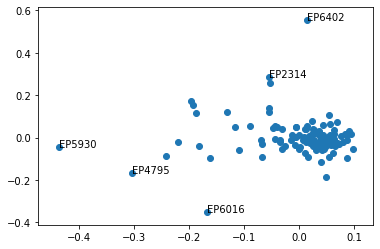

In [7]:
#outlier removal from 2 ancestral principal(?) components.

#matching available ancestrial PC ID 
european_ancestral_PCA_w_outliers=preprocessing.extract_by_ID(european_ID_list,ancestral_PCA_european['ID'],ancestral_PCA_european)
print(european_ancestral_PCA_w_outliers.shape)

from scipy import stats
zscores=np.abs(stats.zscore(european_ancestral_PCA_w_outliers[:,1:3].astype('float64'),axis=0))
outliers=np.where(zscores>3)[0]#remove anything more than 3 st. deviation from the mean.
print(european_ancestral_PCA_w_outliers[outliers,0])
#removing outliers using the ancestrial PCA

fig,ax= plt.subplots()
ax.scatter(european_ancestral_PCA_w_outliers[:,1],european_ancestral_PCA_w_outliers[:,2])
for i,txt in enumerate(european_ancestral_PCA_w_outliers[outliers,0]):
    ax.annotate(txt,(european_ancestral_PCA_w_outliers[outliers,1][i],european_ancestral_PCA_w_outliers[outliers,2][i]))


In [8]:
#Updated lists to remove the outliers:

european_ID_list_without_outliers=preprocessing.extract_by_ID(european_ancestral_PCA_w_outliers[outliers,0],european_ID_list,european_ID_list,remove=True)

###########################################################

#extracting the european connectivity matrices
european_connectivity_matrices_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,ID,babies_connectivity_matrix)
#extracting the european structural matrices
european_structural_matrices_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,babies_structural_matrix['Subject ID'],babies_structural_matrix)
print(european_connectivity_matrices_schizophrenia.shape)
print(european_structural_matrices_schizophrenia.shape)
#matching available ancestrial PC ID // i am transforming all data to array list so I can work easier with scikit learn later on (is it necessary? idk)
european_ancestral_PCA=preprocessing.extract_by_ID(european_ID_list_without_outliers,ancestral_PCA_european['ID'],ancestral_PCA_european)
print(european_ancestral_PCA.shape)
#matching available PRS score with european ID
european_prs_schizophrenia=preprocessing.extract_by_ID(european_ID_list_without_outliers,schizophrenia_high_scores_european['ID'],schizophrenia_high_scores_european)
print(european_prs_schizophrenia.shape)

(117, 90, 90)
(117, 94)
(117, 11)
(117, 7)


In [9]:
#extracting ages, total volume, gender
european_age_at_scan=european_structural_matrices_schizophrenia[:,2]
european_gestational_age=european_structural_matrices_schizophrenia[:,4]
european_gender=european_structural_matrices_schizophrenia[:,3]
european_total_volume=european_structural_matrices_schizophrenia[:,92]
european_volumes=european_structural_matrices_schizophrenia[:,5:92]
european_icv=np.sum(european_volumes,axis=1)

print(european_volumes.shape)

(117, 87)


In [10]:
#extracting the lower triangles of the connectivity matrices and make them into 1D vectors of size (4005,)
inputs_european_connectivity_matrices_schizophrenia=np.asarray(list(map(preprocessing.lower_triangle,european_connectivity_matrices_schizophrenia)))
combinations=preprocessing.lower_triangle(ROIs_combinations)

print(inputs_european_connectivity_matrices_schizophrenia.shape)
print(combinations.shape)

(117, 4005)
(4005,)


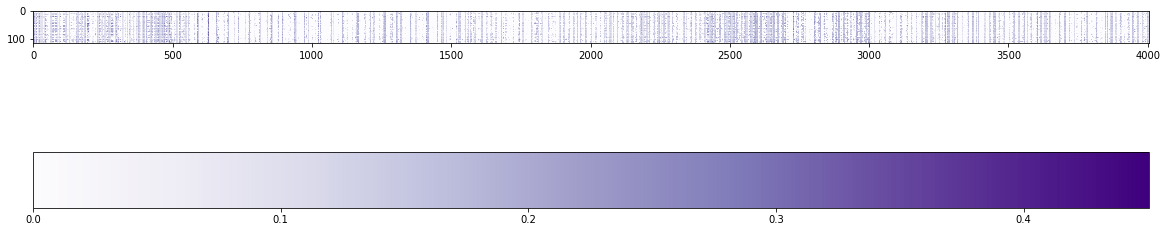

In [11]:
#visualising the connections
fig,ax=plt.subplots(figsize=(20,10))
im=ax.imshow(inputs_european_connectivity_matrices_schizophrenia,cmap='Purples')
fig.colorbar(im,orientation='horizontal',pad=0.2)
plt.show()
mode=stats.mode(inputs_european_connectivity_matrices_schizophrenia)[0][0]
connections_w_zeros_val=combinations[np.where(mode==0)[0]]

as we can see, the connection registrations are fairly consistent between the babies

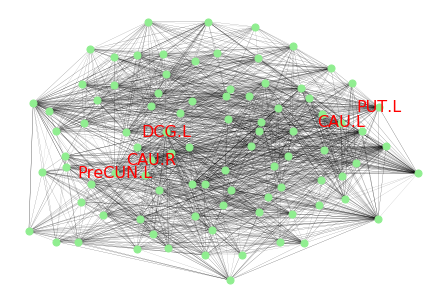

In [10]:
test=preprocessing.ROIs_combo(combinations,inputs_european_connectivity_matrices_schizophrenia[0])
test_graph=test.Graph
visualisation.nx_kamada_kawai_layout(test_graph)

# Adjusting for covariates

In [12]:
#adjusting for covariates:
#for PRS: I adjusted for 10 PC. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=european_prs_schizophrenia[:,1:],covariates=[european_ancestral_PCA[:,1:]])
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_connectivity_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=inputs_european_connectivity_matrices_schizophrenia,covariates=[european_age_at_scan,european_gestational_age,european_icv,european_gender])

adjusted_european_structural_schizophrenia=preprocessing.adjusting_for_covariates_with_lin_reg(y=european_volumes,covariates=[european_age_at_scan,european_gestational_age,european_icv,european_gender])
adjusted_european_structural_schizophrenia=adjusted_european_structural_schizophrenia.astype('float64')


In [12]:
test=running_model.FeatureReduction(greedy=False).fit(X=adjusted_european_connectivity_schizophrenia,y=adjusted_european_PRS_schizophrenia[:,0])

len of combination_index is:2732
len of combination_index is:2410


In [16]:
test.transform(adjusted_european_connectivity_schizophrenia)

shape of new_X is: (117, 2410)
shape of new_X is: (117, 2503)


array([[-0.03144088,  0.02277799,  0.05504168, ..., -0.00488028,
        -0.00925897, -0.01779537],
       [-0.03084207,  0.02797722, -0.076342  , ..., -0.00028703,
         0.00506558, -0.01399008],
       [-0.03056647,  0.12410393, -0.06302398, ...,  0.0044298 ,
        -0.00228633, -0.00405397],
       ...,
       [-0.01813773,  0.03676316,  0.09771346, ..., -0.00896719,
        -0.01486926, -0.00681563],
       [-0.03587205, -0.03373642, -0.07420595, ...,  0.00360064,
         0.00506867, -0.02272935],
       [ 0.1837337 ,  0.16400724,  0.17026885, ...,  0.00652428,
         0.13919536,  0.20170985]])

In [17]:
test.pca_dict_name

{0: ['PCA_39.41.87.95.110.114.258.262.280.298.329.333.339.349.411.415.474.2419.2439.2441.2490.2494.2633.2637.2643_0',
  'PCA_39.41.87.95.110.114.258.262.280.298.329.333.339.349.411.415.474.2419.2439.2441.2490.2494.2633.2637.2643_1',
  'PCA_39.41.87.95.110.114.258.262.280.298.329.333.339.349.411.415.474.2419.2439.2441.2490.2494.2633.2637.2643_2'],
 1: ['PCA_58.81.112.139.143.153.155.159.172.178.237.268.409.468.472.484.531.535.1599.1615.2659_0',
  'PCA_58.81.112.139.143.153.155.159.172.178.237.268.409.468.472.484.531.535.1599.1615.2659_1',
  'PCA_58.81.112.139.143.153.155.159.172.178.237.268.409.468.472.484.531.535.1599.1615.2659_2'],
 2: ['PCA_378.396.524.1568.2173.2306.2433.2481.2574.2622.2624.2916.3226.3542_0',
  'PCA_378.396.524.1568.2173.2306.2433.2481.2574.2622.2624.2916.3226.3542_1',
  'PCA_378.396.524.1568.2173.2306.2433.2481.2574.2622.2624.2916.3226.3542_2'],
 3: ['PCA_47.122.126.169.231.233.249.256.453.1542.1558.2558.2578.2586_0',
  'PCA_47.122.126.169.231.233.249.256.453.1542.

# Univariate Testing

In [277]:
#UNIVARIATE TESTING. Calculated by first estimating fitting a simple linear model to each regressor, and then calculate the R2. From R2, we calculate the F-score and with that P-value. The False discovery rate method adjust the p-value.

from sklearn.feature_selection import f_regression, SelectFdr
from statsmodels.stats.multitest import fdrcorrection #I used fdrcorrection because the SelectFdr does not return array of adjusted p-values, which is stupid, because it already calculated it, might as well output it.

print('#################connectivity######################')

for p_threshold in range(adjusted_european_PRS_schizophrenia.shape[1]):

    F_score,p_value=f_regression(adjusted_european_connectivity_schizophrenia,adjusted_european_PRS_schizophrenia[:,p_threshold])
    survived_idx,adjusted_p_values=fdrcorrection(p_value,alpha=0.05)
    print('For p_threshold of %s, %d features were significant, but %d survived the FDR correction' %(schizophrenia_high_scores_european.columns[p_threshold+1],
    len(p_value[p_value<0.05]),len(np.where(survived_idx)[0])))

print('#################structural######################')

for p_threshold in range(adjusted_european_PRS_schizophrenia.shape[1]):

    F_score,p_value=f_regression(adjusted_european_structural_schizophrenia,adjusted_european_PRS_schizophrenia[:,p_threshold])
    survived_idx,adjusted_p_values=fdrcorrection(p_value,alpha=0.05)
    print('For p_threshold of %s, %d features were significant, but %d survived the FDR correction' %(schizophrenia_high_scores_european.columns[p_threshold+1],
    len(p_value[p_value<0.05]),len(np.where(survived_idx)[0])))

#################connectivity######################
For p_threshold of 0.100000, 160 features were significant, and/but 0 survived the FDR correction
For p_threshold of 0.200000, 140 features were significant, and/but 0 survived the FDR correction
For p_threshold of 0.300000, 132 features were significant, and/but 0 survived the FDR correction
For p_threshold of 0.400000, 132 features were significant, and/but 0 survived the FDR correction
For p_threshold of 0.500000, 149 features were significant, and/but 0 survived the FDR correction
For p_threshold of 1.000000, 150 features were significant, and/but 0 survived the FDR correction
#################structural######################
For p_threshold of 0.100000, 7 features were significant, but 0 survived the FDR correction
For p_threshold of 0.200000, 4 features were significant, but 0 survived the FDR correction
For p_threshold of 0.300000, 4 features were significant, but 0 survived the FDR correction
For p_threshold of 0.400000, 4 fea

Run across multiple searching events